# Covertype

In [54]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from tqdm import tqdm

import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice
    
key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split

from functools import partial
import kernels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
covtype = datasets.fetch_covtype()
features, labels = covtype['data'], covtype['target']

num_features = features.shape[-1]
num_classes = len(onp.unique(labels))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# TODO: need to normalize data, etc before stuff will work

In [53]:
def get_batches(x, y, n_steps=500, batch_size=500):
    """Split x and y into batches"""
    assert len(x) == len(y)
    batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
    return islice(batch_cycle, n_steps)

num_batches = len(x_train) // 500

In [55]:
batches = get_batches(x_train, y_train, batch_size=5)

We can define the model using `tfd.JointDistributionCoroutine`. We'll put standard normal priors on both the weights and the bias term then write a `target_log_prob` function that pins the sampled labels to the data.

In [8]:
Root = tfd.JointDistributionCoroutine.Root

def get_model(features_batch):
    def model():
        """generator"""
        w = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_features, num_classes), name="w"))
        b = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,),              name="b"))
        logits = jnp.dot(features_batch, w) + b
        _ = yield tfd.Independent(tfd.Categorical(logits=logits), reinterpreted_batch_ndims=1, name="labels")
    return model


def get_logp(x_batch, y_batch):
    """Stochastic estimate of the log-density (up to additive constant)
    based on batch"""
    def logp(params):
        dist = tfd.JointDistributionCoroutine(get_model(x_batch))
        return dist.log_prob(tuple(params) + (y_batch,))
    return logp

dist = tfd.JointDistributionCoroutine(get_model(x_train[:300]))

Note that we have two distinct types of batching going on: we're using batches of data to estimate the gradient $\nabla \log p$, and then we're mapping that gradient over a set of particles.

In [9]:
x, y = next(batches)
logp = get_logp(x, y)

dist = tfd.JointDistributionCoroutine(get_model(x))
*params, label = dist.sample(seed=key)
print(dist.log_prob(params + [y]))
print(logp(params))

# now batched!
*params, label = dist.sample(5, seed=key)
vmap(logp)(params)

-24053.352
-24053.352


DeviceArray([-51325.812 , -42315.832 , -19196.648 ,  -3738.0188,
             -15562.641 ], dtype=float32)

# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

In [10]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [11]:
def get_flat_logp(x_batch, y_batch):
    logp = get_logp(x_batch, y_batch)
    def flat_logp(params_flat):
        return logp(unravel(params_flat))
    return flat_logp

def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

In [12]:
def run_lmc(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    particles = batch_ravel(init_batch)
    eta = 1e-3
    logps = []

    @jit
    def step(key, particles, x, y):
        logp = get_flat_logp(x, y)
        log_probs, grads = vmap(value_and_grad(logp))(particles)
        particles += eta * grads + np.sqrt(2*eta) * random.normal(key, shape=particles.shape)
        return particles, log_probs

    n_steps = num_batches*2
    for x, y in tqdm(get_batches(x_train, y_train, n_steps), total=n_steps):
        key, subkey = random.split(key)
        particles, log_probs = step(subkey, particles, x, y)
        logps.append(log_probs)
    return batch_unravel(particles), np.array(logps)

In [13]:
def run_svgd(init_batch):
    """init_batch is a batch of initial samples / particles."""
    particles = batch_ravel(init_batch)
    eta = 1e-3
    logps = []

    @jit
    def step(particles, x, y):
        logp = get_flat_logp(x, y)
        kernel = kernels.get_rbf_kernel(kernels.median_heuristic(particles))
        phistar = stein.get_phistar(kernel, logp, particles)
        log_probs = vmap(logp)(particles)
        return particles + eta * vmap(phistar)(particles), log_probs

    n_steps = num_batches*2
    for x, y in tqdm(get_batches(x_train, y_train, n_steps), total=n_steps):
        particles, log_probs = step(particles, x, y)
        logps.append(log_probs)
    return batch_unravel(particles), np.array(logps)

In [14]:
# def run_neural_svgd(key, init_batch):
#     """init_batch is a batch of initial samples / particles."""
#     init_batch = batch_ravel(init_batch)
#     key, keya, keyb = random.split(key, 3)
#     learner = models.SDLearner(target_logp=logp, target_dim=init_batch.shape[1], key=keya)

#     particles = models.Particles(key=keyb,
#                                  gradient=learner.gradient,
#                                  init_samples=init_batch,
#                                  learning_rate=1e-3,
#                                  num_groups=2)
#     next_batch = partial(particles.next_batch, batch_size=None)
#     for x, y in get_batches(x_train, y_train, 10):
#         key, subkey = random.split(key)
#         learner.train(next_batch, key=subkey, n_steps=1)
#         particles.step(learner.get_params())
#     return batch_unravel(particles.particles.training), learner, particles

In [15]:
init_batch = dist.sample(100, seed=key)[:-1]
lmc_samples, lmc_logps = run_lmc(key, init_batch)
svgd_samples, svgd_logps = run_svgd(init_batch)
# neural_samples, neural_gradient, neural_particles = run_neural_svgd(key, init_batch)

100%|██████████| 1858/1858 [00:53<00:00, 34.96it/s]


## Evaluate samples on test set

In [16]:
@jit
def test_accuracy(samples):
    # get logits
    test_dist = tfd.JointDistributionCoroutine(get_model(x_test))

    def get_logits(params):
        """Returns logits shaped (n, 7), 7 being nr of categories"""
        dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
        logits = dists[-1].distribution.probs_parameter()
        return logits
    logits = vmap(get_logits)(samples)
    return np.mean(logits.mean(axis=0).argmax(axis=-1) == y_test)

In [17]:
test_accuracy(lmc_samples)

DeviceArray(0.43242428, dtype=float32)

In [18]:
test_accuracy(svgd_samples)

DeviceArray(0.3680628, dtype=float32)

In [19]:
print(test_accuracy(dist.sample(500, seed=key)[:-1]))
print(100/7)

0.10732081
14.285714285714286


In [42]:
scipy.stats.describe(lmc_samples[0].flatten())

DescribeResult(nobs=37800, minmax=(-1886.4893, 1460.1361), mean=0.0056622326, variance=42752.953, skewness=-2.643146276473999, kurtosis=38.401330486692686)

### compute test log-likelihood

In [20]:
x_test.shape

(116203, 54)

In [21]:
test_batches = get_batches(x_test, y_test, batch_size=5000)

In [22]:
x, y = next(test_batches)
test_logp = get_logp(x, y)

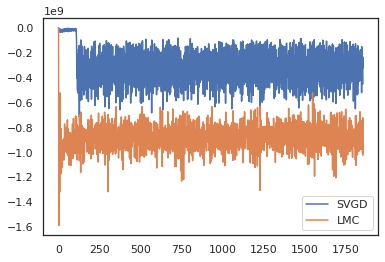

In [32]:
plt.plot(svgd_logps.mean(axis=1), label="SVGD");
plt.plot(lmc_logps.mean(axis=1), label="LMC");
plt.legend()

In [27]:
lmc_test_logp = np.mean(vmap(test_logp)(lmc_samples))
svgd_test_logp = np.mean(vmap(test_logp)(svgd_samples))

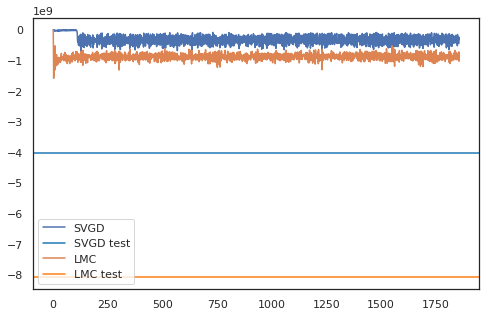

In [34]:
fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(svgd_logps.mean(axis=1), label="SVGD")
ax.axhline(y=svgd_test_logp, label="SVGD test", color="tab:blue")

ax.plot(lmc_logps.mean(axis=1), label="LMC")
ax.axhline(y=lmc_test_logp, label="LMC test", color="tab:orange")

plt.legend()